# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6360e4e0-1728-4996-658d-2209069cec00)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-02-17 08:23:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.008s  

2023-02-17 08:23:46 (20.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


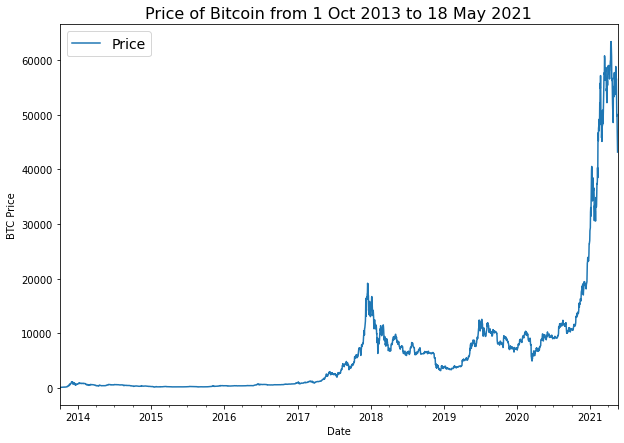

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

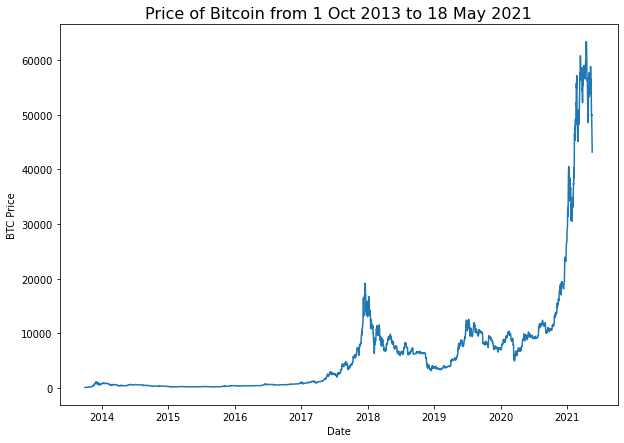

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

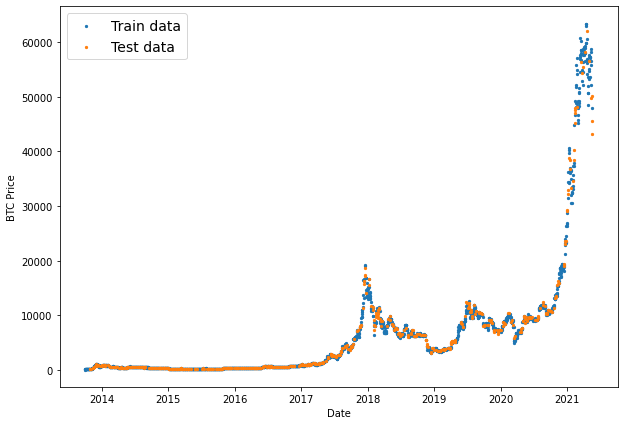

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

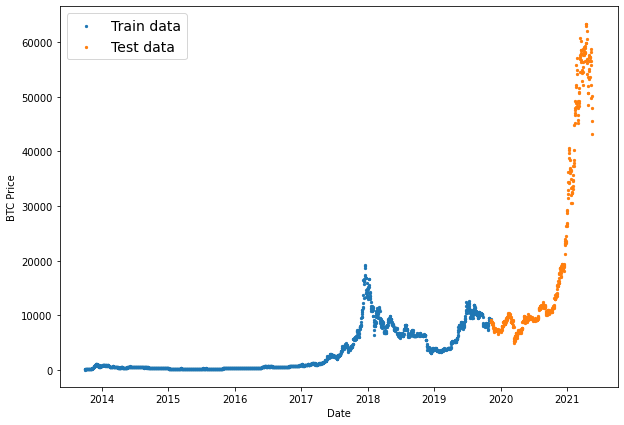

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

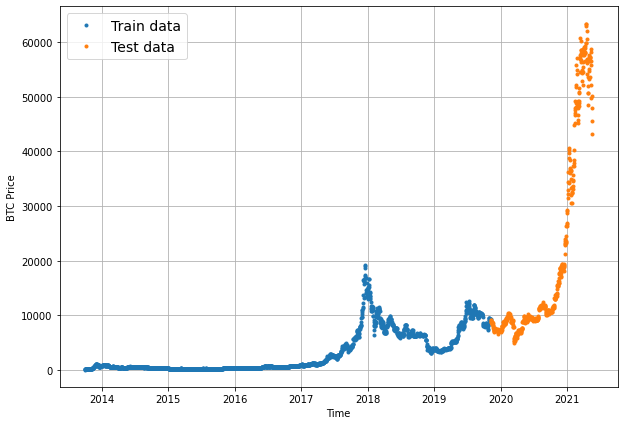

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

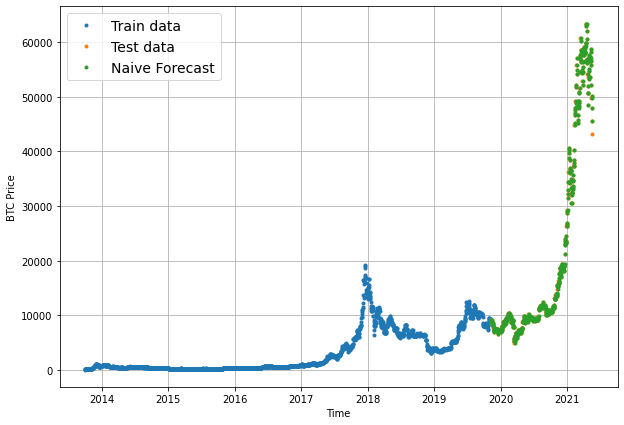

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

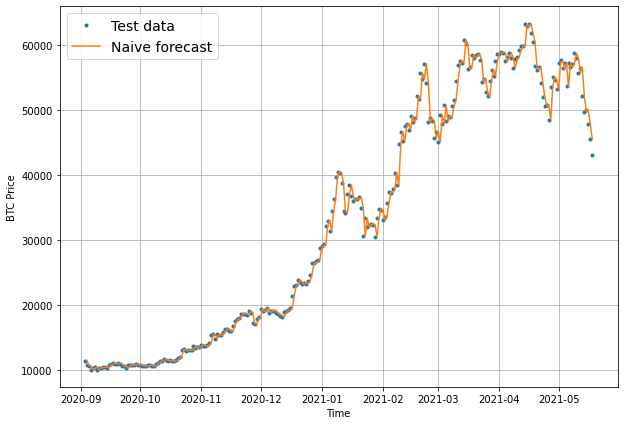

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 1:14 - loss: 2946.3369 - mae: 2946.3369

18/18 [==============================] - 6s 69ms/step - loss: 1219.0841 - mae: 1219.0841 - val_loss: 2397.6985 - val_mae: 2397.6985
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 310.7632 - mae: 310.7632

18/18 [==============================] - 1s 35ms/step - loss: 310.7632 - mae: 310.7632 - val_loss: 1332.2478 - val_mae: 1332.2478
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 180.3270 - mae: 180.3270

18/18 [==============================] - 1s 36ms/step - loss: 176.7085 - mae: 176.7085 - val_loss: 1002.5452 - val_mae: 1002.5452
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 165.0530 - mae: 165.0530

18/18 [==============================] - 1s 35ms/step - loss: 159.8215 - mae: 159.8215 - val_loss: 871.9315 - val_mae: 871.9315
Epoch 5/100
14/18 [======================>.......] - ETA: 0s - loss: 156.2182 - mae: 156.2182

18/18 [==============================] - 1s 36ms/step - loss: 152.8399 - mae: 152.8399 - val_loss: 835.8313 - val_mae: 835.8313
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 147.3293 - mae: 147.3293

18/18 [==============================] - 1s 57ms/step - loss: 151.3427 - mae: 151.3427 - val_loss: 815.1184 - val_mae: 815.1183
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 150.6710 - mae: 150.6710

18/18 [==============================] - 1s 64ms/step - loss: 145.9592 - mae: 145.9592 - val_loss: 806.1976 - val_mae: 806.1976
Epoch 8/100
13/18 [====================>.........] - ETA: 0s - loss: 141.3926 - mae: 141.3926

18/18 [==============================] - 1s 50ms/step - loss: 140.0510 - mae: 140.0510 - val_loss: 767.8659 - val_mae: 767.8659
Epoch 9/100
12/18 [===================>..........] - ETA: 0s - loss: 142.3697 - mae: 142.3697

18/18 [==============================] - 1s 44ms/step - loss: 139.6069 - mae: 139.6069 - val_loss: 755.6666 - val_mae: 755.6666
Epoch 10/100
 8/18 [============>.................] - ETA: 0s - loss: 129.5466 - mae: 129.5466

18/18 [==============================] - 1s 37ms/step - loss: 134.0395 - mae: 134.0395 - val_loss: 727.5439 - val_mae: 727.5439
Epoch 11/100
18/18 [==============================] - 0s 4ms/step - loss: 128.7411 - mae: 128.7411 - val_loss: 743.8815 - val_mae: 743.8815
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 127.8266 - mae: 127.8266 - val_loss: 744.0305 - val_mae: 744.0305
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 110.9364 - mae: 110.9364

18/18 [==============================] - 1s 35ms/step - loss: 128.5768 - mae: 128.5768 - val_loss: 723.0673 - val_mae: 723.0673
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 123.1273 - mae: 123.1273

18/18 [==============================] - 1s 35ms/step - loss: 123.1273 - mae: 123.1273 - val_loss: 691.1768 - val_mae: 691.1768
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 120.8028 - mae: 120.8028

18/18 [==============================] - 1s 54ms/step - loss: 123.8706 - mae: 123.8706 - val_loss: 668.4894 - val_mae: 668.4894
Epoch 16/100
18/18 [==============================] - 0s 7ms/step - loss: 120.2266 - mae: 120.2266 - val_loss: 678.2198 - val_mae: 678.2198
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 119.0467 - mae: 119.0467 - val_loss: 679.0331 - val_mae: 679.0331
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 132.4081 - mae: 132.4081

18/18 [==============================] - 1s 34ms/step - loss: 118.4351 - mae: 118.4351 - val_loss: 643.6649 - val_mae: 643.6649
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 117.1551 - mae: 117.1551 - val_loss: 666.4463 - val_mae: 666.4463
Epoch 20/100
18/18 [==============================] - 0s 10ms/step - loss: 115.5932 - mae: 115.5932 - val_loss: 645.5197 - val_mae: 645.5197
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 140.5300 - mae: 140.5300

18/18 [==============================] - 1s 38ms/step - loss: 119.2079 - mae: 119.2079 - val_loss: 636.9595 - val_mae: 636.9595
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 115.3542 - mae: 115.3542 - val_loss: 661.5587 - val_mae: 661.5587
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 110.4081 - mae: 110.4081

18/18 [==============================] - 1s 32ms/step - loss: 117.4140 - mae: 117.4140 - val_loss: 636.4203 - val_mae: 636.4203
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 121.1063 - mae: 121.1063

18/18 [==============================] - 1s 42ms/step - loss: 113.2696 - mae: 113.2696 - val_loss: 620.3376 - val_mae: 620.3376
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5273 - mae: 112.5273 - val_loss: 640.8680 - val_mae: 640.8680
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 114.4788 - mae: 114.4788

18/18 [==============================] - 1s 37ms/step - loss: 116.5311 - mae: 116.5311 - val_loss: 609.2061 - val_mae: 609.2061
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 159.0746 - mae: 159.0746

18/18 [==============================] - 1s 36ms/step - loss: 114.0196 - mae: 114.0196 - val_loss: 603.1382 - val_mae: 603.1382
Epoch 28/100
18/18 [==============================] - 0s 8ms/step - loss: 111.9670 - mae: 111.9670 - val_loss: 609.2495 - val_mae: 609.2495
Epoch 29/100
18/18 [==============================] - 0s 8ms/step - loss: 111.7113 - mae: 111.7113 - val_loss: 608.0975 - val_mae: 608.0975
Epoch 30/100
18/18 [==============================] - 0s 4ms/step - loss: 114.1501 - mae: 114.1501 - val_loss: 623.9962 - val_mae: 623.9962
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 114.0195 - mae: 114.0195 - val_loss: 606.5048 - val_mae: 606.5048
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 110.8880 - mae: 110.8880

18/18 [==============================] - 1s 33ms/step - loss: 110.3199 - mae: 110.3199 - val_loss: 598.3509 - val_mae: 598.3509
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 110.9588 - mae: 110.9588 - val_loss: 642.8549 - val_mae: 642.8549
Epoch 34/100
18/18 [==============================] - 0s 10ms/step - loss: 110.4281 - mae: 110.4281 - val_loss: 604.9519 - val_mae: 604.9519
Epoch 35/100
 9/18 [==============>...............] - ETA: 0s - loss: 104.9562 - mae: 104.9562

18/18 [==============================] - 1s 63ms/step - loss: 108.9189 - mae: 108.9189 - val_loss: 590.2027 - val_mae: 590.2027
Epoch 36/100
18/18 [==============================] - ETA: 0s - loss: 111.3969 - mae: 111.3969

18/18 [==============================] - 1s 69ms/step - loss: 111.3969 - mae: 111.3969 - val_loss: 589.9286 - val_mae: 589.9286
Epoch 37/100
12/18 [===================>..........] - ETA: 0s - loss: 106.6318 - mae: 106.6318

18/18 [==============================] - 1s 48ms/step - loss: 108.4320 - mae: 108.4320 - val_loss: 586.5223 - val_mae: 586.5223
Epoch 38/100
18/18 [==============================] - 0s 9ms/step - loss: 108.6919 - mae: 108.6919 - val_loss: 587.8496 - val_mae: 587.8496
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 109.7028 - mae: 109.7028 - val_loss: 588.3898 - val_mae: 588.3898
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 109.2221 - mae: 109.2221 - val_loss: 627.9478 - val_mae: 627.9478
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 111.7188 - mae: 111.7188

18/18 [==============================] - 0s 26ms/step - loss: 109.1002 - mae: 109.1002 - val_loss: 582.8066 - val_mae: 582.8066
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 110.0245 - mae: 110.0245 - val_loss: 634.8358 - val_mae: 634.8358
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3761 - mae: 112.3761 - val_loss: 629.9586 - val_mae: 629.9586
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 68.6055 - mae: 68.6055

18/18 [==============================] - 0s 26ms/step - loss: 111.4416 - mae: 111.4416 - val_loss: 581.5383 - val_mae: 581.5383
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 106.8465 - mae: 106.8465 - val_loss: 598.8118 - val_mae: 598.8118
Epoch 46/100
18/18 [==============================] - 0s 7ms/step - loss: 108.7910 - mae: 108.7910 - val_loss: 586.6833 - val_mae: 586.6833
Epoch 47/100
18/18 [==============================] - 0s 9ms/step - loss: 108.6476 - mae: 108.6476 - val_loss: 636.3978 - val_mae: 636.3978
Epoch 48/100
 9/18 [==============>...............] - ETA: 0s - loss: 105.7073 - mae: 105.7073

18/18 [==============================] - 1s 39ms/step - loss: 107.1613 - mae: 107.1613 - val_loss: 577.5317 - val_mae: 577.5317
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3743 - mae: 108.3743 - val_loss: 660.0117 - val_mae: 660.0117
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2124 - mae: 115.2124 - val_loss: 611.4694 - val_mae: 611.4694
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2692 - mae: 109.2692 - val_loss: 580.8762 - val_mae: 580.8762
Epoch 52/100
14/18 [======================>.......] - ETA: 0s - loss: 110.8776 - mae: 110.8776

18/18 [==============================] - 1s 45ms/step - loss: 108.2384 - mae: 108.2384 - val_loss: 576.6731 - val_mae: 576.6731
Epoch 53/100
18/18 [==============================] - 0s 8ms/step - loss: 108.6787 - mae: 108.6787 - val_loss: 604.6309 - val_mae: 604.6309
Epoch 54/100
18/18 [==============================] - 0s 8ms/step - loss: 107.8276 - mae: 107.8276 - val_loss: 581.2412 - val_mae: 581.2412
Epoch 55/100
14/18 [======================>.......] - ETA: 0s - loss: 114.6880 - mae: 114.6880

18/18 [==============================] - 1s 58ms/step - loss: 109.6002 - mae: 109.6002 - val_loss: 576.0914 - val_mae: 576.0914
Epoch 56/100
18/18 [==============================] - 0s 11ms/step - loss: 106.9280 - mae: 106.9280 - val_loss: 798.6582 - val_mae: 798.6582
Epoch 57/100
18/18 [==============================] - 0s 11ms/step - loss: 124.2662 - mae: 124.2662 - val_loss: 675.1189 - val_mae: 675.1189
Epoch 58/100
10/18 [===============>..............] - ETA: 0s - loss: 114.9338 - mae: 114.9338

18/18 [==============================] - 1s 55ms/step - loss: 114.6496 - mae: 114.6496 - val_loss: 574.9343 - val_mae: 574.9343
Epoch 59/100
18/18 [==============================] - 0s 12ms/step - loss: 106.3636 - mae: 106.3636 - val_loss: 590.3799 - val_mae: 590.3799
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 107.4202 - mae: 107.4202 - val_loss: 613.0243 - val_mae: 613.0243
Epoch 61/100
10/18 [===============>..............] - ETA: 0s - loss: 102.2056 - mae: 102.2056

18/18 [==============================] - 1s 49ms/step - loss: 107.5571 - mae: 107.5571 - val_loss: 572.2369 - val_mae: 572.2369
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 106.8585 - mae: 106.8585 - val_loss: 631.7711 - val_mae: 631.7711
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 113.1324 - mae: 113.1324 - val_loss: 620.8827 - val_mae: 620.8827
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 111.0926 - mae: 111.0926 - val_loss: 691.4077 - val_mae: 691.4077
Epoch 65/100
18/18 [==============================] - 0s 11ms/step - loss: 111.5588 - mae: 111.5588 - val_loss: 572.8098 - val_mae: 572.8098
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0146 - mae: 107.0146 - val_loss: 574.3778 - val_mae: 574.3778
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 106.3866 - mae: 106.3866 - val_loss: 658.5374 - val_mae: 658.5374
Epoch 68/100
18/18 [===========

18/18 [==============================] - 1s 56ms/step - loss: 105.2464 - mae: 105.2464 - val_loss: 571.8638 - val_mae: 571.8638
Epoch 75/100
18/18 [==============================] - 0s 9ms/step - loss: 106.3954 - mae: 106.3954 - val_loss: 594.0065 - val_mae: 594.0065
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 108.4039 - mae: 108.4039 - val_loss: 591.8893 - val_mae: 591.8893
Epoch 77/100
18/18 [==============================] - 0s 13ms/step - loss: 107.4813 - mae: 107.4813 - val_loss: 573.2802 - val_mae: 573.2802
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 107.1449 - mae: 107.1449 - val_loss: 580.8787 - val_mae: 580.8787
Epoch 79/100
18/18 [==============================] - 0s 12ms/step - loss: 107.0348 - mae: 107.0348 - val_loss: 591.0146 - val_mae: 591.0146
Epoch 80/100
18/18 [==============================] - 0s 10ms/step - loss: 106.8497 - mae: 106.8497 - val_loss: 622.3909 - val_mae: 622.3909
Epoch 81/100
18/18 [=========

18/18 [==============================] - 1s 45ms/step - loss: 105.3773 - mae: 105.3773 - val_loss: 570.6937 - val_mae: 570.6937
Epoch 86/100
12/18 [===================>..........] - ETA: 0s - loss: 99.1604 - mae: 99.1604  

18/18 [==============================] - 1s 36ms/step - loss: 105.0056 - mae: 105.0056 - val_loss: 570.5531 - val_mae: 570.5531
Epoch 87/100
18/18 [==============================] - 0s 10ms/step - loss: 104.6888 - mae: 104.6888 - val_loss: 587.8853 - val_mae: 587.8853
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 106.8027 - mae: 106.8027 - val_loss: 571.7103 - val_mae: 571.7103
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 104.8801 - mae: 104.8801 - val_loss: 580.1868 - val_mae: 580.1868
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 108.1332 - mae: 108.1332 - val_loss: 703.6685 - val_mae: 703.6685
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3344 - mae: 112.3344 - val_loss: 622.2188 - val_mae: 622.2188
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 106.2141 - mae: 106.2141 - val_loss: 612.4007 - val_mae: 612.4007
Epoch 93/100
18/18 [===========

18/18 [==============================] - 1s 33ms/step - loss: 104.9239 - mae: 104.9239 - val_loss: 570.3143 - val_mae: 570.3143
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 111.8450 - mae: 111.8450 - val_loss: 609.1948 - val_mae: 609.1948
Epoch 97/100
14/18 [======================>.......] - ETA: 0s - loss: 107.8040 - mae: 107.8040

18/18 [==============================] - 1s 37ms/step - loss: 106.7944 - mae: 106.7944 - val_loss: 568.9554 - val_mae: 568.9554
Epoch 98/100
18/18 [==============================] - 0s 8ms/step - loss: 106.4907 - mae: 106.4907 - val_loss: 572.2962 - val_mae: 572.2962
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 148.3607 - mae: 148.3607

18/18 [==============================] - 1s 35ms/step - loss: 106.4503 - mae: 106.4503 - val_loss: 567.4634 - val_mae: 567.4634
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 114.0764 - mae: 114.0764 - val_loss: 633.2603 - val_mae: 633.2603


In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 633.2603 - mae: 633.2603


[633.26025390625, 633.26025390625]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 567.4633 - mae: 567.4633


[567.4633178710938, 567.4633178710938]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8851.618 , 8775.401 , 9046.562 , 8761.072 , 8717.9795, 8754.771 ,
        8688.347 , 8502.496 , 8464.91  , 8532.496 ], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 567.4633,
 'mse': 1167259.0,
 'rmse': 1080.3976,
 'mape': 2.5415285,
 'mase': 0.9968759}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

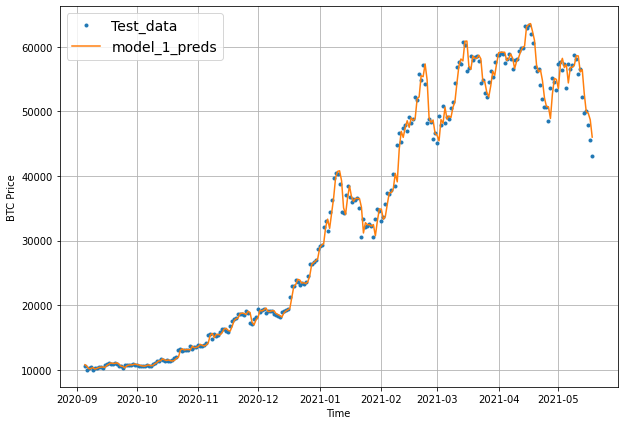

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [46]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [47]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [48]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 622.6552


622.6552124023438

In [49]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 622.6552


622.6552124023438

In [51]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([56538.914, 59206.906, 56940.934, 57225.527, 56599.88 , 53135.098,
       50612.02 , 50583.113, 48655.938, 46453.594], dtype=float32)>

In [52]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [53]:
model_2_results

{'mae': 622.6553,
 'mse': 1346825.2,
 'rmse': 1160.528,
 'mape': 2.8166957,
 'mase': 1.0884075}